<a href="https://colab.research.google.com/github/leejooan/tumor_segmentation/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
    from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 821 kB 5.4 MB/s 


In [ ]:
path0 = '/content/drive/MyDrive/AI/project/brats18_train' # replace your data path
dpiv = 80

In [ ]:
path1 = '/content/drive/MyDrive/AI/project/brats18_test' # replace your data path
dpiv = 80

In [ ]:
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    CenterSpatialCropd,
    NormalizeIntensityd,
    RandSpatialCropd,
    MapTransform,
    ToTensord,
)
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

from monai.transforms import(
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandRotate90d,
    ScaleIntensityd,
    CropForegroundd,
    AdjustContrastd, 
    Spacingd,
    ThresholdIntensityd,
     RandAdjustContrastd,
    Invertd,
   EnsureTyped,
   HistogramNormalized,
   RandGaussianNoised,
    EnsureChannelFirstd,
    GaussianSmooth,
    RandCropByPosNegLabeld,
)

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
path_list = glob.glob(os.path.join(path0,'Brats18*'))
len(path_list)

94

In [ ]:
path_test = glob.glob(os.path.join(path1,'Brats18*'))
len(path_test)

20

### data split (train/valid)

In [ ]:
train_ind = np.arange(0,80)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in train_ind
]
train_files =  data_dicts

In [ ]:
valid_ind = np.arange(80,94)
data_dicts = [
    {
        "image": os.path.join(path_list[idx],
                                    "t1ce.nii.gz"),
        "label": os.path.join(path_list[idx],
                                    "seg.nii.gz"),
    }
    for idx in valid_ind
]
valid_files =  data_dicts

In [ ]:
test_ind = np.arange(0,20)
data_dicts = [
    {
        "image": os.path.join(path_test[idx],
                                    "t1ce.nii.gz"),
    }
    for idx in test_ind
]
test_files =  data_dicts

In [ ]:
from monai.transforms.croppad.dictionary import RandCropByPosNegLabeld
from monai.transforms.intensity.dictionary import RandGaussianNoised
train_transforms = Compose(  
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      CenterSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 96]),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandSpatialCropd(keys=["image", "label"], roi_size=[160, 160, 64],random_size=False),
      ToTensord(keys=["image", "label"]),
     
     RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
     RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
     RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
     RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
     RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
     RandGaussianNoised(keys=["image"], prob=0.5, mean=0,std=0.05),
     
    ]
)

valid_transforms = Compose(
    [
      LoadImaged(keys=("image","label")),
      AddChanneld(keys=("image","label")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image", "label"]),
    
    ]
)

test_transforms = Compose(
    [
      LoadImaged(keys=("image")),
      AddChanneld(keys=("image")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image"]),
     
    ]
)

In [ ]:
train_ds = Dataset(data = train_files, transform = train_transforms)
train_loader = DataLoader(train_ds,batch_size = 2)

In [ ]:
valid_ds = Dataset(data = valid_files, transform = valid_transforms)
valid_loader = DataLoader(valid_ds,batch_size = 1)

In [ ]:
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds,batch_size = 1)

torch.Size([2, 1, 160, 160, 64])
torch.Size([2, 1, 160, 160, 64])


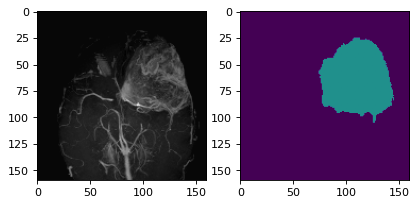

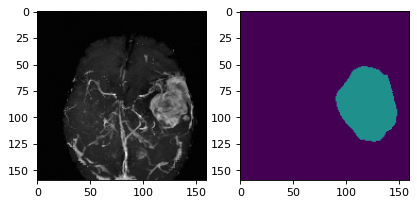

In [ ]:
cnt = 0
for data in train_loader:
  print(data["image"].shape)
  print(data["label"].shape)

  for n in range(0,len(data["image"])):
    plt.figure(dpi=dpiv)
    plt.subplot(121)
    plt.imshow(np.transpose(np.max(data["image"][n,0,:,:,:].numpy(),axis=2),(1,0)),cmap='gray')  

    label = (data["label"]==1).type(torch.FloatTensor) + (data["label"]==2).type(torch.FloatTensor) + (data["label"]==4).type(torch.FloatTensor) 
    plt.subplot(122)
    plt.imshow(np.transpose(np.max(label[n,0,:,:,:].numpy(),axis=2),(1,0)),vmin=0,vmax=2)
    plt.show()

  break
 

# Model

In [ ]:

device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)


/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:139: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


# Train

In [ ]:
root_dir = path0 

max_epochs = 300
val_interval = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

#optimizer = torch.optim.Adam(model.parameters(), lr)
#Adam===>adamW
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"],
        )

        labels = (labels==1).type(torch.FloatTensor) + (labels==4).type(torch.FloatTensor)
        labels[labels>0] = 1
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
       
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
 
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            disp_val_no = np.random.randint(len(valid_files))
            for val_data in valid_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"],
                )        

                val_labels = (val_labels==1).type(torch.FloatTensor)  + (val_labels==4).type(torch.FloatTensor)
                val_labels[val_labels>0] = 1
                val_labels = val_labels.to(device)
                
                roi_size = (160, 160, 64)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.75)
                val_loss = loss_function(val_outputs, val_labels)   
                
                metric_count += 1
                metric_sum += (1-val_loss.sum().item())
                
                if metric_count == disp_val_no:
                  print(val_data['image_meta_dict']['filename_or_obj'])
                  zz = np.argmax(np.sum(np.sum(np.array(val_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
                  val_preds = val_outputs.softmax(1)
                  plt.figure(dpi=dpiv)
                  plt.subplot(131)
                  plt.imshow(np.transpose(val_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
                  plt.axis('off')
                  plt.title('ceT1 MRI')
                  plt.subplot(132)
                  plt.imshow(np.transpose(val_labels[0,0,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('ground truth')
                  plt.subplot(133)
                  plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
                  plt.axis('off')
                  plt.title('prediction')
                  plt.show()
                
            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, f"best_metric_model_epoch_{best_metric_epoch}.pth"))    
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}")

----------
epoch 1/300
epoch 1 average loss: 0.6384
----------
epoch 2/300


KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI/project') 

In [ ]:
path_model = '/content/drive/MyDrive/AI/project/model/' # replace your data path
dpiv = 80

In [ ]:
torch.save(model, path_model+'model2.pt')

## plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()